Authors:
- Brent Gerets
- Tim Boghe

# Dataset

We use a real world [credit card transfer dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download). Most of the columns do not have a meaningful name for privacy reasons. There is also a transfer amount column and a column that indicates whether the transfer is fraudulent.

The dataset is very imbalanced, only 0.172% of the transactions are fraudulent.

# Prepare data

Load in the dataset. We do not need the time column since it is not a meaningful feature (it is the time in seconds since the first transaction in the dataset).

In [62]:
import pandas as pd
import numpy as np

data = pd.read_csv('creditcard.csv', sep=',')
data = data.drop("Time", axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Split the data into train and test sets. The training set should only include non-fraud transactions since we want the model to be good at encoding and decoding these, making the fraudulous transactions stand out.

In [63]:
from sklearn.model_selection import train_test_split

non_fraud = data.loc[data["Class"] == 0]
fraud = data.loc[data["Class"] == 1]

X_train, X_test, y_train, y_test = train_test_split(non_fraud.drop("Class", axis=1), non_fraud["Class"], test_size=0.20, random_state=42)

# Add frauds back to the test set
X_test = X_test.append(fraud.drop("Class", axis=1))
y_test = y_test.append(fraud["Class"])

<ipython-input-63-a7f9b823296e>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(fraud.drop("Class", axis=1))
<ipython-input-63-a7f9b823296e>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_test = y_test.append(fraud["Class"])


Scale the data.

In [64]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train and test model

To create an autoencoder, we construct a sequential model with dense layers that gradually decrease in input size and then increase again to the original input size. The decrease in input size functions as an encoder and the increase functions as a decoder.

In [65]:
from enum import auto
import keras

autoencoder = keras.models.Sequential([
    keras.layers.Dense(len(X_train[0]), activation='elu', input_shape=(len(X_train[0]),)),
    keras.layers.Dense(16, activation='elu'),
    keras.layers.Dense(8, activation='elu'),
    keras.layers.Dense(4, activation='elu'),
    keras.layers.Dense(2, activation='elu'),
    keras.layers.Dense(4, activation='elu'),
    keras.layers.Dense(8, activation='elu'),
    keras.layers.Dense(16, activation='elu'),
    keras.layers.Dense(len(X_train[0]), activation='elu')
])

autoencoder.compile(optimizer="adam", loss="mse", metrics=["acc"])

We fit the model using X_train as the features as well as targets, since we want to model to encode and then decode the features again.

In [66]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=4, mode="min")

autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, callbacks=[early_stopping])

Epoch 1/100
889/889 [==============================] - 4s 3ms/step - loss: 0.0125 - acc: 0.9471
Epoch 2/100
889/889 [==============================] - 3s 3ms/step - loss: 0.0022 - acc: 0.9925
Epoch 3/100
889/889 [==============================] - 2s 3ms/step - loss: 0.0021 - acc: 0.9925
Epoch 4/100
889/889 [==============================] - 3s 4ms/step - loss: 0.0020 - acc: 0.9925
Epoch 5/100
889/889 [==============================] - 4s 5ms/step - loss: 0.0018 - acc: 0.9925
Epoch 6/100
889/889 [==============================] - 3s 3ms/step - loss: 0.0017 - acc: 0.9925
Epoch 7/100
889/889 [==============================] - 4s 4ms/step - loss: 0.0017 - acc: 0.9925
Epoch 8/100
889/889 [==============================] - 3s 4ms/step - loss: 0.0017 - acc: 0.9925
Epoch 9/100
889/889 [==============================] - 3s 3ms/step - loss: 0.0017 - acc: 0.9925
Epoch 10/100
889/889 [==============================] - 2s 3ms/step - loss: 0.0017 - acc: 0.9925
Epoch 11/100
889/889 [=================

To measure the performance we let the autoencoder predict on the test set features. The mean squared error then functions as our probability of a given transaction being fraudulous. A higher error means the model had more trouble decoding, which means the transaction is an anomaly and therefor likely fraudulous.

We show the precision ROC and calculate the AUC-PR since this is also the metric we used in the supervised exercise.

1793/1793 [==============================] - 3s 1ms/step
0.6732631153784601


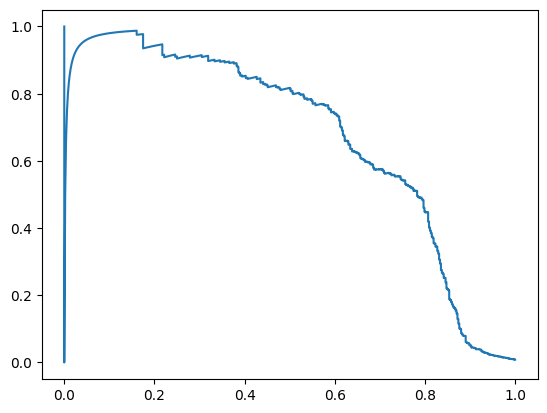

In [70]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

decoded = autoencoder.predict(X_test)
mse = np.array(keras.losses.mse(decoded, X_test))

precision, recall, _ = precision_recall_curve(y_test, mse)
aucpr = auc(recall, precision)
print(aucpr)

plt.plot(recall, precision)
plt.show()